In [1]:
import tensorflow as tf
import numpy as np
import glob 
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy

In [2]:
# 设置该程序可见的GPU：写到最前面！
gpus = tf.config.experimental.list_physical_devices( device_type = 'GPU' )
# 选用GPU：
tf.config.experimental.set_visible_devices( devices = gpus[2:4], device_type = 'GPU' )

### 1. 导入所有文件的路径：

In [3]:
# 所有训练图片的地址：
image_path = glob.glob( '/home/gaoboyu/学习数据集/沙漠数据集12_450/图像/*' )  # *全读入
label_path = glob.glob( '/home/gaoboyu/学习数据集/沙漠数据集12_450/处理后标签/*' )
# 排序：
image_path.sort( key = lambda x:int(x.split('/')[-1].split('.')[0].split('_')[-1]) )
label_path.sort( key = lambda x:int(x.split('/')[-1].split('.')[0].split('_')[-1]) )

In [4]:
image_count = len(image_path)
len(image_path), len(label_path)

(450, 450)

In [5]:
# 最后数据的乱序：
index = np.random.permutation( image_count )
image_path = np.array(image_path)[index]
label_path = np.array(label_path)[index]

### 2. 创建数据集：

In [6]:
dataset = tf.data.Dataset.from_tensor_slices( (image_path, label_path) )

In [7]:
# 划分训练、测试集
val_count = int( image_count*0.2 )
train_count = image_count - val_count

train_dataset = dataset.skip(val_count)  # 跳过前这么多数据
val_dataset = dataset.take(val_count)   # 取前面这么多数据

val_count, train_count

(90, 360)

In [8]:
# 查看：
train_dataset, val_dataset

(<SkipDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 <TakeDataset shapes: ((), ()), types: (tf.string, tf.string)>)

### 3. 预处理函数：

In [9]:
# 读取图片：3通道
def read_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 3)
    return img

In [10]:
# 读取标签：1通道（每个像素都是标签值）
def read_label(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 1)
    return img

In [11]:
# 对训练数据及标签：随机翻转 —— 训练数据专用！
def random_flip(img, label):
    img_label = tf.concat( [img, label], axis = -1 )  # 图像与标签合并
    img_label = tf.image.resize(img_label, [256,256])
    img_label = tf.image.random_flip_left_right(img_label)  # 随机左右翻转
    img_label = tf.image.random_flip_up_down(img_label)     # 随机上下翻转
    return img_label[:,:,0:3], img_label[:,:,3:]

In [12]:
# 所有图像归一化 + 标签转数据类型：
def normal(img, label):
    img = tf.cast(img, tf.float32) / 127.5 - 1
    label = tf.cast(label, tf.int32)  # 不能减1，因为里面本身就有0的标签！ 
    return img, label

In [13]:
# 训练数据加载：需要裁减！
def load_train_image(img_path, label_path):
    # 获取图片与标签：
    img = read_image(img_path)
    label = read_label(label_path)
    # 预处理：随机翻转 —— 自带统一形状！
    img, label = random_flip(img, label)
    # 返回归一化：
    return normal(img, label)

def load_val_image(img_path, label_path):
    # 获取图片与标签：
    img = read_image(img_path)
    label = read_label(label_path)
    # 统一形状：
    img = tf.image.resize(img, [256,256])
    label = tf.image.resize(label, [256,256])
    # 返回归一化：
    return normal(img, label)

In [14]:
# 将数据应用于函数：
AUTOTUNE = tf.data.experimental.AUTOTUNE   # 多线程加载：图像加载是cpu处理的，cpu可以做多线程！

train_dataset = train_dataset.map( load_train_image, num_parallel_calls = AUTOTUNE )
val_dataset = val_dataset.map( load_val_image, num_parallel_calls = AUTOTUNE )

In [15]:
train_dataset, val_dataset

(<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.int32)>,
 <ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.int32)>)

In [16]:
# 乱序、划分数据集：
# cashe()：新操作，文件不断放到缓存中，加速！
# prefetch()：新操作，GPU内存不等待，不断预处理图片
BATCH_SIZE = 10
train_dataset = train_dataset.cache().shuffle(train_count).repeat().batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_dataset = val_dataset.cache().batch(BATCH_SIZE)

In [17]:
train_dataset, val_dataset

(<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>,
 <BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>)

### 4. 模型搭建：将U型加深到8x8

In [18]:
# 以后把模型的自定义，都写到一个函数里 正规！—— 没有输入数据，返回一个模型！—— 层的生成，完全可以用循环！
# 调过拟合：特征提取部分加Dropout!
def create_model():
    inputs = tf.keras.layers.Input( shape = (256,256,3) )  # 所有的层都是大写的！所有这也是一个层！
    
    # 前半部分卷积基自定义：顺序连接 + 用名字获得某层输出
    # 第一部分：_1
    conv2d_1_1 = tf.keras.layers.Conv2D( 64, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_1_1' )(inputs)
    dropout_1_1 = tf.keras.layers.Dropout( 0.6, name = 'dropout_1_1' )(conv2d_1_1)  # dropout
    bn_1_1 = tf.keras.layers.BatchNormalization( name = 'bn_1_1' )(dropout_1_1)
    conv2d_1_2 = tf.keras.layers.Conv2D( 64, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_1_2' )(bn_1_1)
    dropout_1_2 = tf.keras.layers.Dropout( 0.6, name = 'dropout_1_2' )(conv2d_1_2)  # dropout
    bn_1_2 = tf.keras.layers.BatchNormalization( name = 'bn_1_2' )(dropout_1_2)  # 256 x 256 x 64 √
    maxpool_1_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_1_1' )(bn_1_2)   # 128 x 128 x 64
    
    # 第二部分：_2
    conv2d_2_1 = tf.keras.layers.Conv2D( 128, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_2_1' )(maxpool_1_1)
    dropout_2_1 = tf.keras.layers.Dropout( 0.4, name = 'dropout_2_1' )(conv2d_2_1)  # dropout
    bn_2_1 = tf.keras.layers.BatchNormalization( name = 'bn_2_1' )(dropout_2_1)
    conv2d_2_2 = tf.keras.layers.Conv2D( 128, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_2_2' )(bn_2_1)
    dropout_2_2 = tf.keras.layers.Dropout( 0.4, name = 'dropout_2_2' )(conv2d_2_2)  # dropout
    bn_2_2 = tf.keras.layers.BatchNormalization( name = 'bn_2_2' )(dropout_2_2)  # 128 x 128 x 128 √
    maxpool_2_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_2_1' )(bn_2_2)   # 64 x 64 x 128
    
    # 第三部分：_3
    conv2d_3_1 = tf.keras.layers.Conv2D( 256, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_3_1' )(maxpool_2_1)
    dropout_3_1 = tf.keras.layers.Dropout( 0.3, name = 'dropout_3_1' )(conv2d_3_1)  # dropout
    bn_3_1 = tf.keras.layers.BatchNormalization( name = 'bn_3_1' )(dropout_3_1)
    conv2d_3_2 = tf.keras.layers.Conv2D( 256, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_3_2' )(bn_3_1)
    dropout_3_2 = tf.keras.layers.Dropout( 0.3, name = 'dropout_3_2' )(conv2d_3_2)  # dropout
    bn_3_2 = tf.keras.layers.BatchNormalization( name = 'bn_3_2' )(dropout_3_2)  # 64 x 64 x 256 √
    maxpool_3_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_3_1' )(bn_3_2)   # 32 x 32 x 256
    
    # 第四部分：_4
    conv2d_4_1 = tf.keras.layers.Conv2D( 512, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_4_1' )(maxpool_3_1)
    dropout_4_1 = tf.keras.layers.Dropout( 0.2, name = 'dropout_4_1' )(conv2d_4_1)  # dropout
    bn_4_1 = tf.keras.layers.BatchNormalization( name = 'bn_4_1' )(dropout_4_1)
    conv2d_4_2 = tf.keras.layers.Conv2D( 512, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_4_2' )(bn_4_1)
    dropout_4_2 = tf.keras.layers.Dropout( 0.2, name = 'dropout_4_2' )(conv2d_4_2)  # dropout
    bn_4_2 = tf.keras.layers.BatchNormalization( name = 'bn_4_2' )(dropout_4_2)  # 32 x 32 x 512 √
    maxpool_4_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_4_1' )(bn_4_2)   # 16 x 16 x 512  
    
    # 第五部分：_5
    conv2d_5_1 = tf.keras.layers.Conv2D( 1024, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_5_1' )(maxpool_4_1)
    dropout_5_1 = tf.keras.layers.Dropout( 0.1, name = 'dropout_5_1' )(conv2d_5_1)  # dropout
    bn_5_1 = tf.keras.layers.BatchNormalization( name = 'bn_5_1' )(dropout_5_1)
    conv2d_5_2 = tf.keras.layers.Conv2D( 1024, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_5_2' )(bn_5_1)
    dropout_5_2 = tf.keras.layers.Dropout( 0.1, name = 'dropout_5_2' )(conv2d_5_2)  # dropout
    bn_5_2 = tf.keras.layers.BatchNormalization( name = 'bn_5_2' )(dropout_5_2)  # 16 x 16 x 1024 √
    maxpool_5_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_5_1' )(bn_5_2)  # 8 x 8 x 1024
    
    # 第六部分：_6 —— 最后没下采样！
    conv2d_6_1 = tf.keras.layers.Conv2D( 2048, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_6_1' )(maxpool_5_1)
    dropout_6_1 = tf.keras.layers.Dropout( 0.05, name = 'dropout_6_1' )(conv2d_6_1)  # dropout
    bn_6_1 = tf.keras.layers.BatchNormalization( name = 'bn_6_1' )(dropout_6_1)
    conv2d_6_2 = tf.keras.layers.Conv2D( 2048, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_6_2' )(bn_6_1)
    dropout_6_2 = tf.keras.layers.Dropout( 0.05, name = 'dropout_6_2' )(conv2d_6_2)  # dropout
    bn_6_2 = tf.keras.layers.BatchNormalization( name = 'bn_6_2' )(dropout_6_2)  # 8 x 8 x 2048 
    
    # 后半部分自定义：反卷积 + 跳接（带√的）
    
    # 第一部分：x1、x2
    # 上采样：上采用的卷积核是(2,2)
    x1 = tf.keras.layers.Conv2DTranspose( 1024, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x1')(bn_6_2)  # 16 x 16
    bn_x1 = tf.keras.layers.BatchNormalization( name = 'bn_x1' )(x1)  # 16 x 16 x 1024
    # 跳接合并：当成一个层！—— 每个Conv后跟一个Dropout
    x2 = tf.concat( [bn_x1, bn_5_2], axis = -1 )  # 16 x 16 x (1024+1024) = 16 x 16 x 2048
    conv2d_x2_1 = tf.keras.layers.Conv2D( 1024, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x2_1' )(x2)
    dropout_x2_1 = tf.keras.layers.Dropout( 0.2, name = 'dropout_x2_1' )(conv2d_x2_1)  # dropout
    bn_x2_1 = tf.keras.layers.BatchNormalization( name = 'bn_x2_1' )(dropout_x2_1)
    conv2d_x2_2 = tf.keras.layers.Conv2D( 1024, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x2_2' )(bn_x2_1)
    dropout_x2_2 = tf.keras.layers.Dropout( 0.2, name = 'dropout_x2_2' )(conv2d_x2_2)  # dropout
    bn_x2_2 = tf.keras.layers.BatchNormalization( name = 'bn_x2_2' )(dropout_x2_2)  # 16 x 16 x 1024
    
    # 第二部分：x3、x4
    # 上采样：上采用的卷积核是(2,2)
    x3 = tf.keras.layers.Conv2DTranspose( 512, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x3')(bn_x2_2)  # 32 x 32
    bn_x3 = tf.keras.layers.BatchNormalization( name = 'bn_x3' )(x3)  # 32 x 32 x 512
    # 跳接合并：当成一个层！—— 每个Conv后跟一个Dropout
    x4 = tf.concat( [bn_x3, bn_4_2], axis = -1 )  # 32 x 32 x (512+512) = 32 x 32 x 1024
    conv2d_x4_1 = tf.keras.layers.Conv2D( 512, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x4_1' )(x4)
    dropout_x4_1 = tf.keras.layers.Dropout( 0.15, name = 'dropout_x4_1' )(conv2d_x4_1)  # dropout
    bn_x4_1 = tf.keras.layers.BatchNormalization( name = 'bn_x4_1' )(dropout_x4_1)
    conv2d_x4_2 = tf.keras.layers.Conv2D( 512, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x4_2' )(bn_x4_1)
    dropout_x4_2 = tf.keras.layers.Dropout( 0.15, name = 'dropout_x4_2' )(conv2d_x4_2)  # dropout
    bn_x4_2 = tf.keras.layers.BatchNormalization( name = 'bn_x4_2' )(dropout_x4_2)  # 32 x 32 x 512
    
    # 第三部分：x5、x6
    # 上采样：上采用的卷积核是(2,2)
    x5 = tf.keras.layers.Conv2DTranspose( 256, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x5')(bn_x4_2)  # 64 x 64
    bn_x5 = tf.keras.layers.BatchNormalization( name = 'bn_x5' )(x5)  # 64 x 64 x 256
    # 跳接合并：当成一个层！—— 每个Conv后跟一个Dropout
    x6 = tf.concat( [bn_x5, bn_3_2], axis = -1 )  # 64 x 64 x (256+256) = 64 x 64 x 512
    conv2d_x6_1 = tf.keras.layers.Conv2D( 256, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x6_1' )(x6)
    dropout_x6_1 = tf.keras.layers.Dropout( 0.1, name = 'dropout_x6_1' )(conv2d_x6_1)  # dropout
    bn_x6_1 = tf.keras.layers.BatchNormalization( name = 'bn_x6_1' )(dropout_x6_1)
    conv2d_x6_2 = tf.keras.layers.Conv2D( 256, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x6_2' )(bn_x6_1)
    dropout_x6_2 = tf.keras.layers.Dropout( 0.1, name = 'dropout_x6_2' )(conv2d_x6_2)  # dropout
    bn_x6_2 = tf.keras.layers.BatchNormalization( name = 'bn_x6_2' )(dropout_x6_2)  # 64 x 64 x 512
    
    # 第四部分：x7、x8
    # 上采样：上采用的卷积核是(2,2)
    x7 = tf.keras.layers.Conv2DTranspose( 128, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x7' )(bn_x6_2)  # 128 x 128
    bn_x7 = tf.keras.layers.BatchNormalization( name = 'bn_x7' )(x7)  # 128 x 128 x 128
    # 跳接合并：当成一个层！—— 每个Conv后跟一个Dropout
    x8 = tf.concat( [bn_x7, bn_2_2], axis = -1 )  # 128 x 128 x (128+128) = 128 x 128 x 256
    conv2d_x8_1 = tf.keras.layers.Conv2D( 128, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x8_1' )(x8)
    dropout_x8_1 = tf.keras.layers.Dropout( 0.05, name = 'dropout_x8_1' )(conv2d_x8_1)  # dropout
    bn_x8_1 = tf.keras.layers.BatchNormalization( name = 'bn_x8_1' )(dropout_x8_1)
    conv2d_x8_2 = tf.keras.layers.Conv2D( 128, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x8_2' )(bn_x8_1)
    dropout_x8_2 = tf.keras.layers.Dropout( 0.05, name = 'dropout_x8_2' )(conv2d_x8_2)  # dropout
    bn_x8_2 = tf.keras.layers.BatchNormalization( name = 'bn_x8_2' )(dropout_x8_2)  # 128 x 128 x 128
    
    # 第五部分：x9、x10
    x9 = tf.keras.layers.Conv2DTranspose( 64, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x9' )(bn_x8_2)  # 256 x 256
    bn_x9 = tf.keras.layers.BatchNormalization( name = 'bn_x9' )(x9)  # 256 x 256 x 64
    # 跳接合并：当成一个层！—— 每个Conv后跟一个Dropout
    x10 = tf.concat( [bn_x9, bn_1_2], axis = -1 )  # 256 x 256 x (64+64) = 256 x 256 x 128
    conv2d_x10_1 = tf.keras.layers.Conv2D( 64, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x10_1' )(x10)
    dropout_x10_1 = tf.keras.layers.Dropout( 0.05, name = 'dropout_x10_1' )(conv2d_x10_1)  # dropout
    bn_x10_1 = tf.keras.layers.BatchNormalization( name = 'bn_x10_1' )(dropout_x10_1)
    conv2d_x10_2 = tf.keras.layers.Conv2D( 64, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x10_2' )(bn_x10_1)
    dropout_x10_2 = tf.keras.layers.Dropout( 0.05, name = 'dropout_x10_2' )(conv2d_x10_2)  # dropout
    bn_x10_2 = tf.keras.layers.BatchNormalization( name = 'bn_x10_2' )(dropout_x10_2)  # 256 x 256 x 64
    
    # 最后的通道数变为2：卷积核为(1,1)；激活函数用softmax
    # 最后输出大小：256 x 256 x 2
    output = tf.keras.layers.Conv2D(2, kernel_size = (1,1), strides = (1,1), padding = 'same', activation = 'softmax', name = 'output')(bn_x10_2)
    
    # 模型搭建：
    model = tf.keras.Model( inputs = inputs, outputs = output )
    return model 

In [19]:
model = create_model()

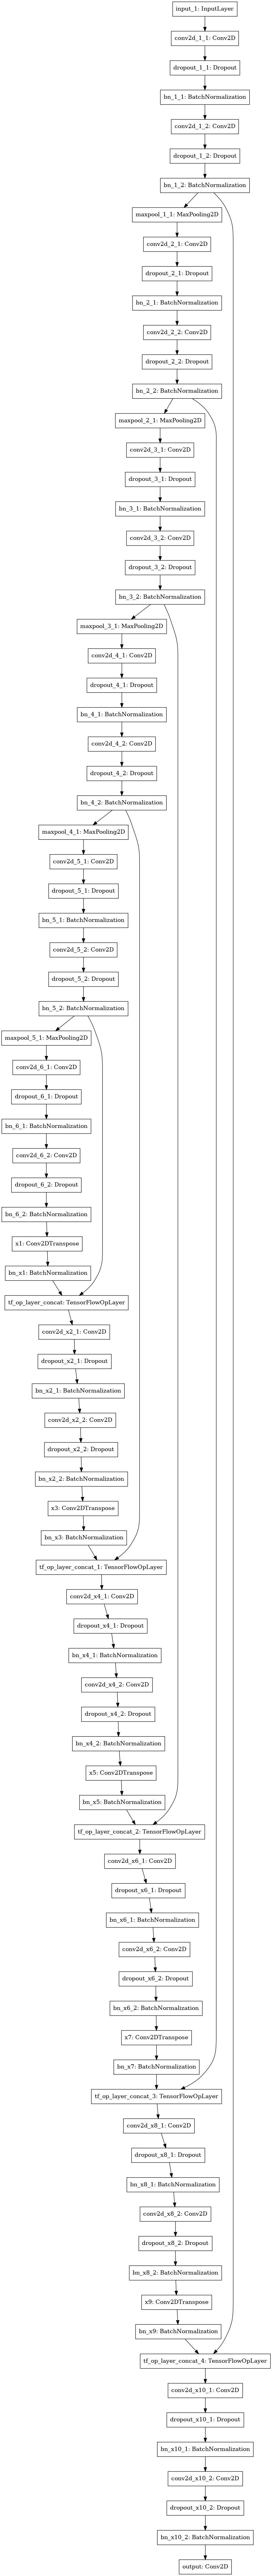

In [20]:
# 画出网络拓扑图：
tf.keras.utils.plot_model(model, show_shapes = False, expand_nested = False, to_file = '沙漠Unet_8x8.png')

In [20]:
# 模型编译
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

In [21]:
# 定义保存模型的回调函数：保存整个模型、只保存最好的！
# 设置保存的路径：
checkpoint_path = '/home/gaoboyu/学习保存的模型/沙漠12_8x8_2'
# 设置回调函数保存模型：没设置的参数都默认
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = 'val_acc',
    save_best_only = True  # 监控的目标：如果新的epoch结果比前一个要好，那就重新保存最新的，删掉旧的！
)

In [22]:
# 模型训练
EPOCHES = 150
history = model.fit(
    train_dataset,
    epochs = EPOCHES,
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    callbacks = [cp_callback]
)

Epoch 1/150
36/36 [==============================] - ETA: 0s - loss: 0.6063 - acc: 0.7735WARNING:tensorflow:From /usr/local/Anaconda33/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/gaoboyu/学习保存的模型/沙漠12_8x8_2/assets
36/36 [==============================] - 74s 2s/step - loss: 0.6063 - acc: 0.7735 - val_loss: 1.4960 - val_acc: 0.9053
Epoch 2/150
36/36 [==============================] - 69s 2s/step - loss: 0.4047 - acc: 0.9036 - val_loss: 1.5145 - val_acc: 0.9053
Epoch 3/150
36/36 [==============================] - 58s 2s/step - loss: 0.2834 - acc: 0.9197 - val_loss: 1.4541 - val_acc: 0.9053
Epoch 4/150
36/36 [==============================] - 58s 2s/step - loss: 0.2247 - acc: 

In [12]:
# 将数据应用于函数：
AUTOTUNE = tf.data.experimental.AUTOTUNE   # 多线程加载：图像加载是cpu处理的，cpu可以做多线程！
dataset = dataset.map( load_val_image, num_parallel_calls = AUTOTUNE )

In [15]:
BATCH_SIZE = 10
dataset = dataset.cache().batch(BATCH_SIZE)
dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>

In [18]:
# model = tf.keras.models.load_model( '/home/gaoboyu/学习保存的模型dataset漠11_8x8_2' )
model = tf.keras.models.load_model( 'model12_450_调过拟合.h5' )

In [19]:
model.evaluate(val_dataset)

9/9 [==============================] - 4s 399ms/step - loss: 0.1807 - acc: 0.9498


[0.18072709441184998, 0.9497509598731995]

In [23]:
# 降速训练1（0.0001）：再次编译 + 再次训练
model.compile(
    optimizer = tf.keras.optimizers.Adam( lr = 0.001 ),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

# 再次训练：
initial_epochs = EPOCHES
final_epochs = 20  # 再多训练10个epoch
total_epochs = initial_epochs + final_epochs

history = model.fit(
    train_dataset,
    epochs = total_epochs,
    initial_epoch = initial_epochs,  # 数值从initial_epochs开始记录而已！
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    callbacks = [cp_callback]
)

Epoch 151/170
36/36 [==============================] - 59s 2s/step - loss: 0.0711 - acc: 0.9689 - val_loss: 0.2007 - val_acc: 0.9375
Epoch 152/170
36/36 [==============================] - 58s 2s/step - loss: 0.0693 - acc: 0.9697 - val_loss: 0.1909 - val_acc: 0.9395
Epoch 153/170
36/36 [==============================] - 58s 2s/step - loss: 0.0699 - acc: 0.9695 - val_loss: 0.1743 - val_acc: 0.9429
Epoch 154/170
36/36 [==============================] - 58s 2s/step - loss: 0.0701 - acc: 0.9694 - val_loss: 0.1912 - val_acc: 0.9408
Epoch 155/170
36/36 [==============================] - 58s 2s/step - loss: 0.0684 - acc: 0.9702 - val_loss: 0.2142 - val_acc: 0.9398
Epoch 156/170
36/36 [==============================] - 58s 2s/step - loss: 0.0693 - acc: 0.9698 - val_loss: 0.1787 - val_acc: 0.9429
Epoch 157/170
36/36 [==============================] - 58s 2s/step - loss: 0.0678 - acc: 0.9705 - val_loss: 0.1926 - val_acc: 0.9396
Epoch 158/170
36/36 [==============================] - 58s 2s/step - 

In [24]:
# 降速训练1（0.0001）：再次编译 + 再次训练
model.compile(
    optimizer = tf.keras.optimizers.Adam( lr = 0.001 ),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

# 再次训练：
initial_epochs = EPOCHES
final_epochs = 20  # 再多训练10个epoch
total_epochs = initial_epochs + final_epochs

history = model.fit(
    train_dataset,
    epochs = total_epochs,
    initial_epoch = initial_epochs,  # 数值从initial_epochs开始记录而已！
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    callbacks = [cp_callback]
)

Epoch 151/170
36/36 [==============================] - 60s 2s/step - loss: 0.0652 - acc: 0.9716 - val_loss: 0.1973 - val_acc: 0.9393
Epoch 152/170
36/36 [==============================] - 59s 2s/step - loss: 0.0628 - acc: 0.9727 - val_loss: 0.2226 - val_acc: 0.9414
Epoch 153/170
36/36 [==============================] - 59s 2s/step - loss: 0.0627 - acc: 0.9727 - val_loss: 0.2158 - val_acc: 0.9411
Epoch 154/170
36/36 [==============================] - 58s 2s/step - loss: 0.0628 - acc: 0.9726 - val_loss: 0.2150 - val_acc: 0.9413
Epoch 155/170
36/36 [==============================] - 58s 2s/step - loss: 0.0632 - acc: 0.9725 - val_loss: 0.2106 - val_acc: 0.9420
Epoch 156/170
36/36 [==============================] - 58s 2s/step - loss: 0.0620 - acc: 0.9730 - val_loss: 0.2155 - val_acc: 0.9428
Epoch 157/170
36/36 [==============================] - 58s 2s/step - loss: 0.0644 - acc: 0.9720 - val_loss: 0.2174 - val_acc: 0.9385
Epoch 158/170
36/36 [==============================] - 58s 2s/step - 

In [25]:
model.save( 'model12_450_调过拟合.h5' )

In [26]:
# model.evaluate( val_dataset )

In [25]:
model = tf.keras.models.load_model( '/home/gaoboyu/学习保存的模型/沙漠9_8x8_2' )

In [26]:
# 模型训练
model.compile(
    optimizer = tf.keras.optimizers.Adam( lr = 0.0001 ),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

EPOCHES = 30
history = model.fit(
    train_dataset,
    epochs = EPOCHES,
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    # callbacks = [cp_callback]
)

Epoch 1/30
24/24 [==============================] - 39s 2s/step - loss: 0.0564 - acc: 0.9758 - val_loss: 0.2585 - val_acc: 0.9314
Epoch 2/30
24/24 [==============================] - 39s 2s/step - loss: 0.0547 - acc: 0.9765 - val_loss: 0.2548 - val_acc: 0.9318
Epoch 3/30
24/24 [==============================] - 39s 2s/step - loss: 0.0541 - acc: 0.9768 - val_loss: 0.2544 - val_acc: 0.9318
Epoch 4/30
24/24 [==============================] - 38s 2s/step - loss: 0.0540 - acc: 0.9768 - val_loss: 0.2616 - val_acc: 0.9314
Epoch 5/30
24/24 [==============================] - 38s 2s/step - loss: 0.0536 - acc: 0.9771 - val_loss: 0.2596 - val_acc: 0.9315
Epoch 6/30
24/24 [==============================] - 38s 2s/step - loss: 0.0535 - acc: 0.9771 - val_loss: 0.2614 - val_acc: 0.9316
Epoch 7/30
24/24 [==============================] - 37s 2s/step - loss: 0.0527 - acc: 0.9774 - val_loss: 0.2574 - val_acc: 0.9319
Epoch 8/30
24/24 [==============================] - 37s 2s/step - loss: 0.0523 - acc: 0.97

In [27]:
# 模型训练
model.compile(
    optimizer = tf.keras.optimizers.Adam( lr = 0.00001 ),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

EPOCHES = 30
history = model.fit(
    train_dataset,
    epochs = EPOCHES,
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    # 回调函数：
    # callbacks = [cp_callback]
)

Epoch 1/30
24/24 [==============================] - 39s 2s/step - loss: 0.0489 - acc: 0.9791 - val_loss: 0.2813 - val_acc: 0.9312
Epoch 2/30
24/24 [==============================] - 39s 2s/step - loss: 0.0487 - acc: 0.9792 - val_loss: 0.2813 - val_acc: 0.9312
Epoch 3/30
24/24 [==============================] - 38s 2s/step - loss: 0.0486 - acc: 0.9792 - val_loss: 0.2812 - val_acc: 0.9313
Epoch 4/30
24/24 [==============================] - 38s 2s/step - loss: 0.0487 - acc: 0.9792 - val_loss: 0.2808 - val_acc: 0.9312
Epoch 5/30
24/24 [==============================] - 38s 2s/step - loss: 0.0487 - acc: 0.9792 - val_loss: 0.2799 - val_acc: 0.9313
Epoch 6/30
24/24 [==============================] - 37s 2s/step - loss: 0.0486 - acc: 0.9792 - val_loss: 0.2787 - val_acc: 0.9314
Epoch 7/30
24/24 [==============================] - 37s 2s/step - loss: 0.0488 - acc: 0.9791 - val_loss: 0.2816 - val_acc: 0.9311
Epoch 8/30
24/24 [==============================] - 37s 2s/step - loss: 0.0488 - acc: 0.97